---
# **PRUEBA DE MODELOS PARA CLASIFICACIÓN**
---

![](flow_diagram.png)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
X_train_bn = np.load("X_data_bn.npy").astype(np.uint8)

X_test_bn = np.load("X_test_bn.npy").astype(np.uint8)

print("Archivos cargados correctamente.")

Archivos cargados correctamente.


In [3]:
X_train = np.load("X_train_pca95.npy")
y_train = np.load("y_data_bn.npy")

X_test = np.load("X_test_pca95.npy")
y_test = np.load("y_test_bn.npy")

print("Archivos cargados correctamente.")

Archivos cargados correctamente.


In [92]:
y_train_c = np.load("y_data_bn.npy")
y_test_c = np.load("y_test_bn.npy")

In [7]:
# Aplanar las imágenes para entrenar los modelos
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [8]:
X_train_flat.shape

(67692, 10000)

In [9]:
X_train_scaled = X_train_flat/255.0
X_test_scaled  = X_test_flat/255.0 

In [10]:
import gc

del X_train_flat
del X_test_flat
gc.collect()

519

In [11]:
X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled  = X_test_scaled.astype(np.float32)

In [67]:
from sklearn.preprocessing import LabelEncoder

# Convertir las variables categóricas a enteros. 
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test  = encoder.transform(y_test) 

In [68]:
y_train, y_test

(array([  0,   0,   0, ..., 130, 130, 130], dtype=int64),
 array([  0,   0,   0, ..., 130, 130, 130]))

In [69]:
y_train.shape, y_test.shape

((67692,), (22688,))

---
# **Método Bayesiano**
---

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report


gnb = GaussianNB()


params = {
    "var_smoothing": np.logspace(0, -9, num=100)
}

random_search = RandomizedSearchCV(
    estimator = gnb,
    param_distributions=params,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [ ]:
random_search.fit(X_train_scaled, y_train)

---
# **Reducción de dimensionalidad**
---

Como se observó en el código de arriba, entrenar una red con 60,000 muestras y 10,000 características puede ser bastante pesado computacionalmente hablando. 

Se realizará una reducción de dimensionalidad con PCA al 99% de la información, esperando tener un buen equilibrio entre carga computacional y precisión del modelo.  

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)

X_train_reduced = pca.fit_transform(X_train_scaled)

Se obtuvo un ajuste de 10,000 características a 1,044 características: ¡casi 10 veces menos! 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

X_train_reduced = pca.fit_transform(X_train_scaled)

Se redujo de 10,000 características a 188: ¡50 veces menos! 

In [16]:
X_test_reduced = pca.transform(X_test_scaled)

In [ ]:
i_example = 10

image_reduced = pca.inverse_transform(X_train_reduced[i_example])
image_reduced = image_reduced.reshape(100,100)

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1,2,1)
ax1.set_title(f"Imagen original - {y_train[i_example]}")
ax1.imshow(X_train[i_example], cmap="gray")
plt.xticks([])
plt.yticks([])

ax2 = plt.subplot(1,2,2)
ax2.set_title("Imagen reducida al 95% con PCA")
ax2.imshow(image_reduced, cmap="gray")

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
np.save("X_train_pca95.npy", X_train_reduced)
np.save("X_test_pca95.npy", X_test_reduced)

In [ ]:
X_train_reduced.shape

---
# **KNN - Classifier**
---

In [85]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 1, weights= 'uniform')

knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

In [86]:
knn.score(X_test, y_test)

0.8839033850493653

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Crear el modelo KNN
knn = KNeighborsClassifier()

# Definir el espacio de búsqueda de hiperparámetros
params = {
    'n_neighbors': list(range(1,21)),  # Buscar en el rango de 1 a 21 vecinos
    'weights': ['uniform', 'distance'],  # Peso uniforme o basado en la distancia
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distancias posibles
}

# Configurar GridSearchCV 
grid_search = GridSearchCV(
    knn, 
    param_grid=params,
    cv=4,
    verbose=1,
    n_jobs=-1
)

In [12]:
grid_search.fit(X_train, y_train)

print("Mejores parámetros encontrados: ", grid_search.best_params_)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
Mejores parámetros encontrados:  {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


Fitting 4 folds for each of 120 candidates, totalling 480 fits
Mejores parámetros encontrados:  {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}

In [13]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluar el modelo en el conjunto de prueba
y_pred = grid_search.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.77      0.84       164
           1       0.98      0.86      0.91       148
           2       0.95      0.56      0.71       160
           3       0.94      0.93      0.93       164
           4       0.81      0.93      0.86       161
           5       0.98      0.99      0.98       164
           6       0.89      0.89      0.89       152
           7       1.00      0.70      0.82       164
           8       0.99      0.70      0.82       164
           9       0.96      0.74      0.84       144
          10       1.00      1.00      1.00       166
          11       1.00      0.85      0.92       164
          12       0.99      0.94      0.96       219
          13       0.85      0.73      0.78       164
          14       0.95      0.78      0.85       143
          15       0.91      0.94      0.93       166
          16       0.84      0.75      0.80       166
   

---
# **Support Vector Machine**
---

### **1. Probando con kernel lineal**

In [6]:
X_train.shape

(67692, 188)

In [7]:
type(X_train)

numpy.ndarray

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Definir los valores de C para la búsqueda de grilla
param_grid = {'C': [0.01, 0.1, 0.5, 1, 10]}

# Crear el modelo SVM con kernel lineal
svm = SVC(kernel='linear')

# Configurar la búsqueda de grilla
grid_search = GridSearchCV(svm, param_grid, cv=4, verbose=1, n_jobs=-1)

# Ajustar la búsqueda de grilla
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

print(grid_search.best_estimator_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
SVC(C=0.5, kernel='linear')


Fitting 4 folds for each of 5 candidates, totalling 20 fits

SVC(C=0.5, kernel='linear')

In [10]:
# Evaluar el mejor modelo en el conjunto de prueba
score = best_model.score(X_test, y_test)

print("Mejor valor de C:", grid_search.best_params_['C'])
print("Precisión en el conjunto de prueba:", score)

Mejor valor de C: 0.5
Precisión en el conjunto de prueba: 0.8949224259520452


Mejor valor de C: 0.5

Precisión en el conjunto de prueba: 0.8949224259520452

### **2. Probando con kernel polinomial**

In [11]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Reducir el número de valores de C
    'degree': [2, 3, 4]  # Mantener el grado del polinomio bajo
}

# Crear el modelo SVM con kernel polinomial
svm = SVC(kernel='poly')

# Configurar la búsqueda de grilla
grid_search = GridSearchCV(svm, param_grid, cv=4, verbose=1, n_jobs=-1)

# Ajustar la búsqueda de grilla
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

print(grid_search.best_estimator_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
SVC(C=10, degree=2, kernel='poly')


Fitting 4 folds for each of 12 candidates, totalling 48 fits

SVC(C=10, degree=2, kernel='poly')

In [12]:
# Evaluar el mejor modelo en el conjunto de prueba
score = best_model.score(X_test, y_test)

print("Mejor valor de C:", grid_search.best_params_['C'])
print("Precisión en el conjunto de prueba:", score)

Mejor valor de C: 10
Precisión en el conjunto de prueba: 0.8995944992947814


Mejor valor de C: 10

Precisión en el conjunto de prueba: 0.8995944992947814

---
# **Decision Trees**
---

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {"criterion": ["gini", "entropy", "log_loss"], "max_leaf_nodes":list(range(2,100)), "min_samples_split": [2,3,4]}

random_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=50, cv=3, verbose=1, n_jobs=-1)

random_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

print(random_search.best_estimator_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
DecisionTreeClassifier(max_leaf_nodes=98, random_state=42)


In [13]:
# Evaluar el mejor modelo en el conjunto de prueba
score = random_search.score(X_test, y_test)

print("Mejores parámetros:", random_search.best_params_)
print("Precisión en el conjunto de prueba:", score)

Mejores parámetros: {'min_samples_split': 2, 'max_leaf_nodes': 98, 'criterion': 'gini'}
Precisión en el conjunto de prueba: 0.28706805359661497


---
# **Perceptrón multicapa**
---

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Definir el MLPClassifier básico
mlp = MLPClassifier()

# Definir el espacio de hiperparámetros para la búsqueda aleatoria
param_dist = {
    'hidden_layer_sizes': [(randint(50, 300).rvs(), randint(50, 300).rvs()) for _ in range(10)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': uniform(0.001, 0.1),
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=200, verbose=1, cv=4, scoring='accuracy', n_jobs=-1, random_state=42)

# Ajustar el modelo
random_search.fit(X_train, y_train)

# Obtener el mejor modelo y su puntuación
best_mlp = random_search.best_estimator_
best_score = random_search.best_score_

print(f"Mejores hiperparámetros: {random_search.best_params_}")
print(f"Mejor puntuación en validación: {best_score}")

Fitting 4 folds for each of 200 candidates, totalling 800 fits


c:\Users\AlxMa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
14 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\AlxMa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\AlxMa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\AlxMa\AppDa

Mejores hiperparámetros: {'activation': 'logistic', 'alpha': 0.004725347161331479, 'hidden_layer_sizes': (215, 219), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01577390919062267, 'solver': 'adam'}
Mejor puntuación en validación: 0.7299089995863617


Mejores hiperparámetros: {'activation': 'logistic', 'alpha': 0.004725347161331479, 'hidden_layer_sizes': (215, 219), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01577390919062267, 'solver': 'adam'}

Mejor puntuación en validación: 0.7299089995863617

In [8]:
# Evaluar el modelo en el conjunto de prueba
test_score = best_mlp.score(X_test, y_test)
print(f"Puntuación en el conjunto de prueba: {test_score}")

Puntuación en el conjunto de prueba: 0.861953455571227


---
# **Modelos ensamblados**
---

### **1. Hard Voting**

In [10]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(metric='euclidean', n_neighbors=1, weights='uniform')
svm_clf = SVC(C=10, degree=2, kernel='poly', probability=True)
mlp_clf = MLPClassifier(activation='logistic', alpha=0.004725347161331479, hidden_layer_sizes=(215, 219), learning_rate='invscaling', solver='adam')

best_hv = VotingClassifier(estimators = [("knn", knn_clf),("svm", svm_clf),("mlp", mlp_clf)],)
best_score = 0
for i in range(5):
    voting_clf_hard = VotingClassifier(
        estimators = [("knn", knn_clf),
                    ("svm", svm_clf),
                    ("mlp", mlp_clf)],
        voting="hard"
    )

    voting_clf_hard.fit(X_train, y_train) 
    y_pred_hard = voting_clf_hard.predict(X_test)
    accuracy_hard = accuracy_score(y_test, y_pred_hard)
    print(f"Accuracy {i+1} - Hard: {accuracy_hard}")

    if accuracy_hard > best_score:
        best_hv = voting_clf_hard

Accuracy 1 - Hard: 0.8995944992947814
Accuracy 2 - Hard: 0.9028120592383639
Accuracy 3 - Hard: 0.8994622708039492
Accuracy 4 - Hard: 0.9002997179125529
Accuracy 5 - Hard: 0.9021949929478138


In [17]:
y_pred_hard = voting_clf_hard.predict(X_test)
accuracy_hard = accuracy_score(y_test, y_pred_hard)
print("Accuracy - Hard: ", accuracy_hard)
print("")
print(classification_report(y_test, y_pred_hard))

Accuracy - Hard:  0.8834185472496474

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       164
           1       0.89      0.99      0.94       148
           2       0.90      0.78      0.83       160
           3       0.91      0.94      0.92       164
           4       0.80      1.00      0.89       161
           5       0.83      0.98      0.90       164
           6       0.71      0.88      0.78       152
           7       0.67      0.62      0.65       164
           8       0.86      0.73      0.79       164
           9       0.80      0.70      0.75       144
          10       0.86      1.00      0.92       166
          11       0.65      0.88      0.75       164
          12       0.80      1.00      0.89       219
          13       0.84      0.81      0.83       164
          14       0.92      0.85      0.89       143
          15       0.80      0.98      0.88       166
          16       0.63      0.75      0.68

1. **KNN, SVM, MLP**
   * Acc: *90.0%*
2. **KNN, MLP**
   * Acc: *87.42%*
3. **KNN, SVM**
   * Acc: *89.15%*
4. **SVM, MLP**
   * Acc: *88.34%*

### **2. Soft Voting**

In [11]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(metric='euclidean', n_neighbors=1, weights='uniform')
svm_clf = SVC(C=10, degree=2, kernel='poly', probability=True)
mlp_clf = MLPClassifier(activation='logistic', alpha=0.004725347161331479, hidden_layer_sizes=(215, 219), learning_rate='invscaling', solver='adam')

best_sv = VotingClassifier(estimators = [("knn", knn_clf),("svm", svm_clf),("mlp", mlp_clf)],)
best_score = 0
for i in range(5):
    voting_clf_soft = VotingClassifier(
        estimators = [("knn", knn_clf),
                    ("svm", svm_clf),
                    ("mlp", mlp_clf)],
        voting="hard"
    )

    voting_clf_soft.fit(X_train, y_train) 
    y_pred_soft = voting_clf_soft.predict(X_test)
    accuracy_soft = accuracy_score(y_test, y_pred_soft)
    print(f"Accuracy {i+1} - Hard: {accuracy_soft}")

    if accuracy_soft > best_score:
        best_sv = voting_clf_soft

Accuracy 1 - Hard: 0.9006523272214386
Accuracy 2 - Hard: 0.9017542313117066
Accuracy 3 - Hard: 0.8999911847672779
Accuracy 4 - Hard: 0.9006082510578279
Accuracy 5 - Hard: 0.8991096614950634


In [26]:
y_pred_soft = voting_clf_soft.predict(X_test)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
print("Accuracy - Soft: ", accuracy_soft)
print("")
print(classification_report(y_test, y_pred_soft))

Accuracy - Soft:  0.8935119887165022

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       164
           1       0.94      0.74      0.83       148
           2       0.97      0.69      0.81       160
           3       0.94      0.88      0.91       164
           4       0.83      1.00      0.91       161
           5       0.93      0.99      0.96       164
           6       0.87      0.89      0.88       152
           7       0.78      0.53      0.63       164
           8       0.90      0.77      0.83       164
           9       0.91      0.92      0.91       144
          10       0.91      1.00      0.95       166
          11       0.95      0.77      0.86       164
          12       0.97      0.98      0.97       219
          13       0.86      0.85      0.86       164
          14       0.95      0.79      0.86       143
          15       0.93      0.98      0.96       166
          16       0.76      0.70      0.73

1. **KNN, SVM, MLP**
   * Acc: *89.94%*
2. **KNN, MLP**
   * Acc: *88.4%*
3. **KNN, SVM**
   * Acc: *88.39%*
4. **SVM, MLP**
   * Acc: *89.35%*

---
# **Resultado final**
---

In [14]:
svm_clf.fit(X_train, y_train)

SVC(C=10, degree=2, kernel='poly', probability=True)

In [16]:
svm_preds = svm_clf.predict(X_test)
print("SVM accuracy: ", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

SVM accuracy:  0.8995944992947814
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       164
           1       0.90      0.94      0.92       148
           2       0.94      0.66      0.78       160
           3       0.96      0.98      0.97       164
           4       0.81      1.00      0.89       161
           5       1.00      0.95      0.97       164
           6       0.80      0.81      0.81       152
           7       0.94      0.69      0.80       164
           8       0.81      0.68      0.74       164
           9       0.97      0.77      0.86       144
          10       0.99      1.00      0.99       166
          11       0.98      0.85      0.91       164
          12       1.00      0.97      0.98       219
          13       0.90      0.85      0.87       164
          14       0.96      0.80      0.87       143
          15       0.93      0.98      0.95       166
          16       0.68      0.74      0.71    

In [12]:
best_hv.score(X_test, y_test)

0.9021949929478138

In [17]:
y_preds = best_hv.predict(X_test)

'              precision    recall  f1-score   support\n\n           0       0.71      0.73      0.72       164\n           1       0.89      0.94      0.91       148\n           2       0.93      0.63      0.75       160\n           3       0.94      0.95      0.94       164\n           4       0.77      0.98      0.86       161\n           5       0.96      0.98      0.97       164\n           6       0.73      0.83      0.78       152\n           7       0.95      0.74      0.83       164\n           8       0.91      0.76      0.83       164\n           9       0.80      0.82      0.81       144\n          10       0.96      1.00      0.98       166\n          11       0.97      0.92      0.95       164\n          12       0.91      1.00      0.95       219\n          13       0.87      0.83      0.85       164\n          14       0.86      0.90      0.88       143\n          15       0.86      0.99      0.92       166\n          16       0.71      0.76      0.73       166\n       

In [20]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       164
           1       0.89      0.94      0.91       148
           2       0.93      0.63      0.75       160
           3       0.94      0.95      0.94       164
           4       0.77      0.98      0.86       161
           5       0.96      0.98      0.97       164
           6       0.73      0.83      0.78       152
           7       0.95      0.74      0.83       164
           8       0.91      0.76      0.83       164
           9       0.80      0.82      0.81       144
          10       0.96      1.00      0.98       166
          11       0.97      0.92      0.95       164
          12       0.91      1.00      0.95       219
          13       0.87      0.83      0.85       164
          14       0.86      0.90      0.88       143
          15       0.86      0.99      0.92       166
          16       0.71      0.76      0.73       166
          17       0.79    

| Modelo | Tipo de clasificación | Accuracy |
| -------|-----------------------|----------|
| Hard voting  | Hard voting | 90.30% |
| Support Vector Machin | Probabilística | 89.95% |
|K-Nearest Neighbors| Probabilística | 88.39% |
|Multi-layer Perceptron | Probabilística | 86.19% |

In [18]:
import joblib

joblib.dump(svm_clf, "svm_fruits.joblib")
joblib.dump(best_hv, "hard_voting_fruits.joblib")

['hard_voting_fruits.joblib']

### **Predicciones**
---

In [1]:
import joblib

svm_clf = joblib.load("svm_fruits.joblib")
hv_clf = joblib.load("hard_voting_fruits.joblib")

In [7]:
svm_preds = svm_clf.predict(X_test)
hv_preds = hv_clf.predict(X_test)

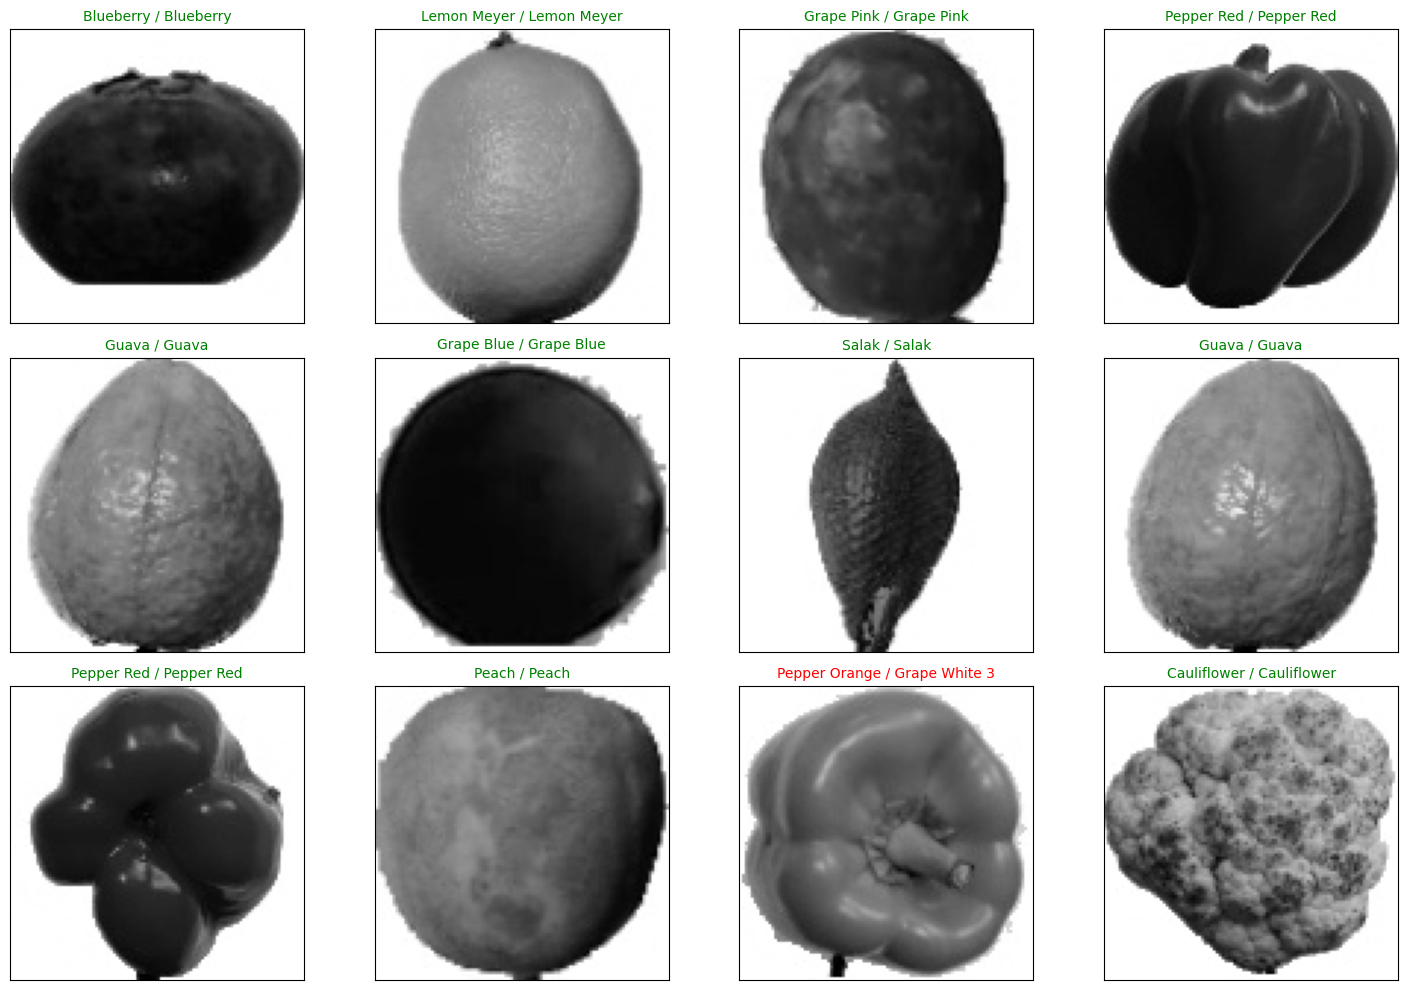

In [50]:
import matplotlib.pyplot as plt
import numpy as np

NCOLS = 4
NROWS = 3

idx = np.random.choice(len(X_test), NCOLS*NROWS)

plt.figure(figsize=(15,10))

for row in range(NROWS): 
    for col in range(NCOLS):     
        i = row*NCOLS + col
        img = X_test[idx[i]]
        img = img.reshape(100,100)
        
        ax = plt.subplot(NROWS, NCOLS, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        org_label, pred = encoder.inverse_transform([y_test[idx[i]], hv_preds[idx[i]]])   
        if hv_preds[idx[i]] == y_test[idx[i]]:
            ax.set_title(f"{org_label} / {pred}", fontdict={"fontsize":10, "color":'g'})
        else:
            ax.set_title(f"{org_label} / {pred}", fontdict={"fontsize":10, "color":'r'})
            
plt.tight_layout()
plt.show()

---
# **Validación con imágenes reales**
---

In [2]:
from PIL import Image
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Guayaba')

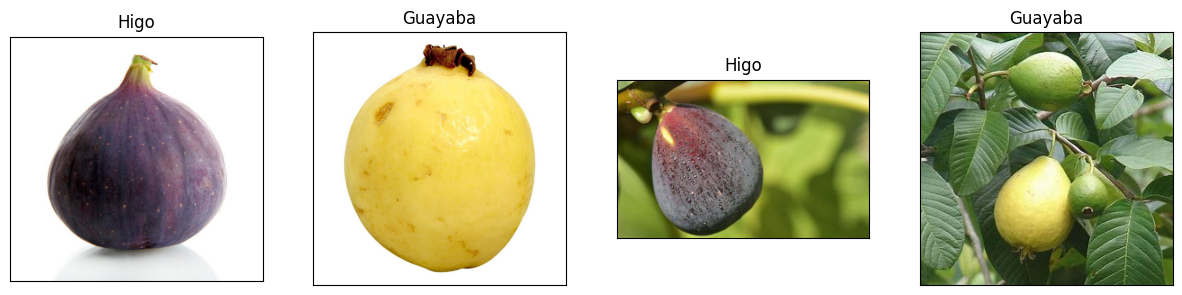

In [146]:
plt.figure(figsize=(15,10))
img = Image.open("higos.jpg")
ax = plt.subplot(1,4,1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
ax.set_title("Higo")

img = Image.open("guayaba.jpeg")
ax = plt.subplot(1,4,2)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
ax.set_title("Guayaba")

img = Image.open("higo2.jpeg")
ax = plt.subplot(1,4,3)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
ax.set_title("Higo")

img = Image.open("guayaba2.jpeg")
ax = plt.subplot(1,4,4)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
ax.set_title("Guayaba")

In [131]:
def preprocess(images_path):
    images = []
    for i,image_path in enumerate(images_path):
        image = Image.open(image_path).convert('L')
        image = image.resize((100,100))
        plt.subplot(1,4,i+1)
        plt.imshow(image, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        image = np.array(image)
        image = image.reshape(-1)
        print(image.shape)
        images.append(image)
    return pca.transform(images)

(10000,)
(10000,)
(10000,)
(10000,)


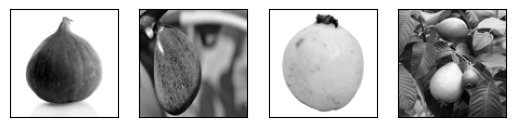

In [132]:
images_pca = preprocess(["higos.jpg", "higo2.jpeg", "Guayaba.jpeg", "Guayaba2.jpeg"])

In [93]:
y_train_c

array(['Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn', ...,
       'Watermelon', 'Watermelon', 'Watermelon'], dtype='<U19')

In [ ]:
y_train_c.unique

In [112]:
labels = np.unique(y_train_c) 

In [118]:
labels

array(['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1',
       'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith',
       'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3',
       'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2',
       'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Fig',
       'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit',
       'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower',
       'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black',
       'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine',
       'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2',
       'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla',
       'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2',
       'Grape White 3', 'Grape White 4', 'Grapefruit Pink',
       'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki',
       'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Mey

In [ ]:
hv_preds = hv_clf.predict(images_pca)
hv_preds

In [135]:
# Mapear las etiquetas a valores enteros usando el diccionario
mapped_preds = [labels[pred] for pred in hv_preds]
print(mapped_preds)

['Fig', 'Fig', 'Fig', 'Fig']


In [136]:
svm_preds = svm_clf.predict(images_pca)
print(svm_preds)
mapped_preds = [labels[pred] for pred in svm_preds]
print(mapped_preds)


[26 26 29 29]
['Cherry 1', 'Cherry 1', 'Guava', 'Guava']


In [138]:
knn_preds = knn.predict(images_pca)
print(knn_preds)
mapped_preds = [labels[pred] for pred in knn_preds]
print(mapped_preds)

[17 17 17 17]
['Fig', 'Fig', 'Fig', 'Fig']
